In [16]:
import numpy as np
import os
#from scipy.misc import imresize
import imageio
from PIL import Image
from skimage.transform import resize
import datetime
import os
#from google.colab import drive
import warnings
#ignore('warnings')
warnings.filterwarnings('ignore')
import cv2

In [17]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [18]:
#drive.mount('/content/gdrive/')
#!unzip /content/gdrive/My\ Drive/DeepLearning/GestureRecog_CaseStudy/Project_data.zip


In [19]:
#/content/Project_data/train.csv
#train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
#batch_size = #experiment with the batch size

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

#train_doc = np.random.permutation(open('C:\\Users\\rajansa\\OneDrive - Lam Research\\QA Folder\\_myLearning\\DeepLearning\\Gesture_Recognition\\Project_data\\train.csv').readlines())
#val_doc = np.random.permutation(open('C:\\Users\\rajansa\\OneDrive - Lam Research\\QA Folder\\_myLearning\\DeepLearning\\Gesture_Recognition\\Project_data\\val.csv').readlines())
# batch_size = 8 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `img_height`,`img_width` and normalization such that you get high accuracy.

In [20]:
def one_batch_data_generator(source_path, t, batch, batch_size, img_idx, img_height, img_width, augment):
  batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

  if augment:
    batch_data_augment = np.zeros((batch_size,len(img_idx),img_height,img_width,3))

  for folder in range(batch_size): # iterate over the batch_size
    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
        image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
        temp = cv2.resize(image,(img_width,img_height))
        temp = temp/255 #Normalize data

        batch_data[folder,idx,:,:,0] = (temp[:,:,0])  #feed in the image
        batch_data[folder,idx,:,:,1] = (temp[:,:,1])  #feed in the image
        batch_data[folder,idx,:,:,2] = (temp[:,:,2])  #feed in the image

        if augment:
          shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))

          gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

          x0, y0 = np.argwhere(gray > 0).min(axis=0)
          x1, y1 = np.argwhere(gray > 0).max(axis=0)

          # cropping the images to have the targeted gestures and remove the noise from the images.
          cropped=shifted[x0:x1,y0:y1,:]

          temp=cv2.resize(cropped,(img_width,img_height))
          temp = temp/255 #Normalize data

          batch_data_augment[folder,idx,:,:,0] = (temp[:,:,0])
          batch_data_augment[folder,idx,:,:,1] = (temp[:,:,1])
          batch_data_augment[folder,idx,:,:,2] = (temp[:,:,2])

    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

  if augment:
    batch_data = np.concatenate([batch_data,batch_data_augment])
    batch_labels = np.concatenate([batch_labels,batch_labels])

  return (batch_data, batch_labels)

In [21]:


def generator(source_path, folder_list, batch_size, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
          batch_data, batch_labels = one_batch_data_generator(source_path, t, batch, batch_size, img_idx, img_height, img_width, augment)
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        last_batch_size = len(folder_list)%(batch_size)
        if last_batch_size != 0: # we check if any folders remaining after the last batch
          batch_data, batch_labels = one_batch_data_generator(source_path, t, num_batches, last_batch_size, img_idx, img_height, img_width, augment)
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Update train and val path accordingly

In [22]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import LSTM


In [24]:
def sample_model():
  #write your model here
  modelA = Sequential()
  modelA.add(Conv3D(64,(3,3,3),padding='same',input_shape=(18,img_width, img_height,3)))
  modelA.add(BatchNormalization())
  modelA.add(Activation('relu'))
  modelA.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

  modelA.add(Conv3D(128,(3,3,3),padding='same'))
  modelA.add(BatchNormalization())
  modelA.add(Activation('relu'))
  #model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,1)))
  modelA.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

  modelA.add(Conv3D(256,(3,3,3),padding='same'))
  modelA.add(BatchNormalization())
  modelA.add(Activation('relu'))
  modelA.add(MaxPooling3D(pool_size=(2, 2,2), strides=(2,2,2)))

  modelA.add(Conv3D(256,(3,3,3),padding='same'))
  modelA.add(BatchNormalization())
  modelA.add(Activation('relu'))
  modelA.add(MaxPooling3D(pool_size=(2, 2,2), strides=(2,2,2)))

  modelA.add(Flatten())
  modelA.add(Dropout(0.25))
  modelA.add(Dense(512, activation = 'relu'))
  #model.add(Activation('elu'))
  #modelA.add(Dropout(0.25))
  #model.add(Dense(len(class_names)))
  modelA.add(Dense(5,activation = 'softmax'))

  optimiser = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True)
  #,weight_decay=None,clipnorm=None,clipvalue=None,global_clipnorm=None,use_ema=False,ema_momentum=0.99,ema_overwrite_frequency=None,jit_compile=True,) #write your optimizer
  modelA.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  #print (modelA.summary())
  return modelA

In [25]:
def train_model(model, batch_size, augment_data=False):
  train_generator = generator(train_path, train_doc,batch_size,augment=augment_data)
  val_generator = generator(val_path, val_doc,batch_size)

  model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

  if not os.path.exists(model_name):
    os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    earlystop = EarlyStopping(monitor='val_loss',verbose=1, patience=5)
    callbacks_list = [checkpoint, LR,earlystop]
    if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
    else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1
    if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
    else:
      validation_steps = (num_val_sequences//batch_size) + 1
  history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

  return history

In [26]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



## Model --1

In [ ]:
img_width = 160
img_height = 160
batch_size=40
img_idx=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
modelA = sample_model()
modelA.summary()
model1=train_model(modelA,batch_size)

**We got Exception Out of Memory for the above model parameters**

## Model 2
With no data agumentation

In [25]:
img_width = 160
img_height = 160
batch_size=8
num_epochs = 25
img_idx=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
modelB = sample_model()
modelB.summary()
model2=train_model(modelB,batch_size)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 160, 160, 64)  5248      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 160, 160, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 160, 160, 64)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 80, 160, 64)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 80, 160, 128)   221312    
                                                                 
 batch_normalization_9 (Batc  (None, 9, 80, 160, 128) 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


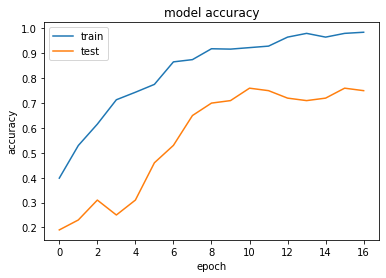

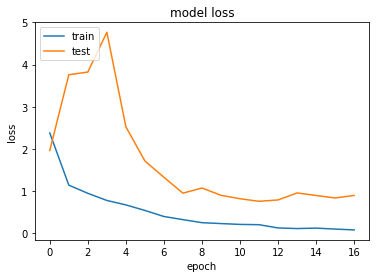

In [26]:
plot_loss_accuracy(model2)

**The model resulted in over fitting with accuracy scores (Training – 0.98, Val – 0.75)**

## Model 3

Alternate Frames with no data agumentation

In [12]:
img_width = 160
img_height = 160
batch_size=8
num_epochs = 25
img_idx=[0,1,3,5,7,9,11,13,15,17,18,19,21,23,25,26,27,29] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
print("No of Frames Used", len(img_idx))
modelC = sample_model()
#print(model)
modelC.summary()
model3=train_model(modelC,batch_size)


No of Frames Used 18


2023-09-06 07:58:38.918874: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-09-06 07:58:38.918943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14796 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 160, 160, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 160, 160, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 160, 160, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 80, 160, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 80, 160, 128)   221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 80, 160, 128)  5

2023-09-06 07:58:41.030559: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


83/83 [==============================] - ETA: 0s - loss: 2.2143 - categorical_accuracy: 0.4600Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2023-09-0607_58_39.066275/model-00001-2.21432-0.46003-3.03875-0.17000.h5
83/83 [==============================] - 62s 680ms/step - loss: 2.2143 - categorical_accuracy: 0.4600 - val_loss: 3.0388 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 0.9938 - categorical_accuracy: 0.6048
Epoch 00002: saving model to model_init_2023-09-0607_58_39.066275/model-00002-0.99381-0.60483-4.45838-0.14000.h5
83/83 [==============================] - 53s 636ms/step - loss: 0.9938 - categorical_accuracy: 0.6048 - val_loss: 4.4584 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 0.7591 - categorical_accuracy: 0.6802
Epoch 00003: saving model to model_init_2023-09-0607_58_39.066275

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


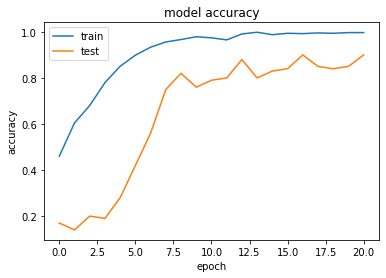

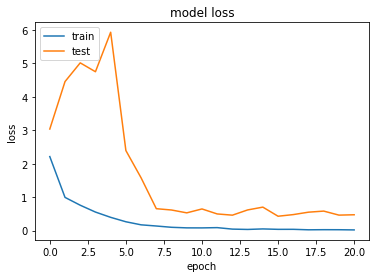

In [13]:
plot_loss_accuracy(model3)

**Slightly overfitting w.r.t to training and validation scores 0.99 and 0.90 respectively, Lets apply data augumentation and see if overfitting is eliminated**

## Module 4

Applying data agumentation to the above model

In [14]:
img_width = 160
img_height = 160
batch_size=8
num_epochs = 25
img_idx=[0,1,3,5,7,9,11,13,15,17,18,19,21,23,25,26,27,29] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
print("No of Frames Used", len(img_idx))
modelD = sample_model()
#print(model)
modelD.summary()
model4=train_model(modelD,batch_size, True)


No of Frames Used 18
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 160, 160, 64)  5248      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 160, 160, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 18, 160, 160, 64)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 80, 160, 64)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 80, 160, 128)   221312    
                                                                 
 batch_normalization_5 (Batc  (No

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


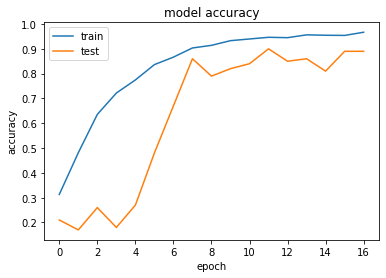

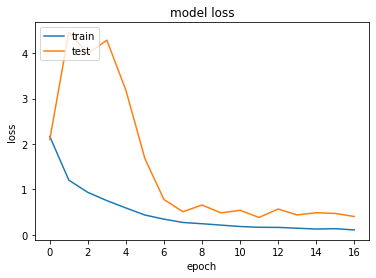

In [16]:
plot_loss_accuracy(model4)

**After applying data augumentaion we see that the model performance is better than above, overfitting is reduced and the validation loss is also improved but the trainable parameters are more let check by reducing the filter size**


## Model 5 - with reduced filter size(2,2,2)

In [18]:
def sample_model_rf():
  #write your model here
  modelB = Sequential()
  modelB.add(Conv3D(64,(2,2,2),padding='same',input_shape=(18,img_width, img_height,3)))
  modelB.add(BatchNormalization())
  modelB.add(Activation('relu'))
  modelB.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

  modelB.add(Conv3D(128,(2,2,2),padding='same'))
  modelB.add(BatchNormalization())
  modelB.add(Activation('relu'))
  #model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,1)))
  modelB.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

  modelB.add(Conv3D(256,(2,2,2),padding='same'))
  modelB.add(BatchNormalization())
  modelB.add(Activation('relu'))
  modelB.add(MaxPooling3D(pool_size=(2, 2,2), strides=(2,2,2)))

  modelB.add(Conv3D(256,(2,2,2),padding='same'))
  modelB.add(BatchNormalization())
  modelB.add(Activation('relu'))
  modelB.add(MaxPooling3D(pool_size=(2, 2,2), strides=(2,2,2)))

  modelB.add(Flatten())
  modelB.add(Dropout(0.25))
  modelB.add(Dense(512, activation = 'relu'))
  #model.add(Activation('elu'))
  #modelB.add(Dropout(0.25))
  #model.add(Dense(len(class_names)))
  modelB.add(Dense(5,activation = 'softmax'))

  optimiser = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True)
  #,weight_decay=None,clipnorm=None,clipvalue=None,global_clipnorm=None,use_ema=False,ema_momentum=0.99,ema_overwrite_frequency=None,jit_compile=True,) #write your optimizer
  modelB.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  #print (modelA.summary())
  return modelB

  

In [19]:
img_width = 160
img_height = 160
batch_size=8
num_epochs = 25
img_idx=[0,1,2,4,5,7,9,11,13,14,15,17,19,21,23,25,27,29] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
print("No of Frames Used", len(img_idx))
modelE = sample_model_rf()
modelE.summary()
#print(model)
model5=train_model(modelE,batch_size, True)

No of Frames Used 18
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 160, 160, 64)  1600      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 160, 160, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 160, 160, 64)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 80, 160, 64)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 80, 160, 128)   65664     
                                                                 
 batch_normalization_9 (Batc  (No

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


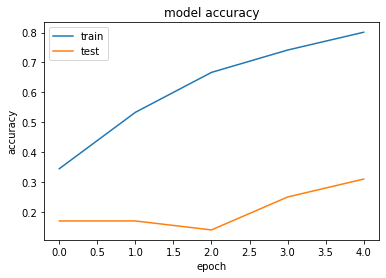

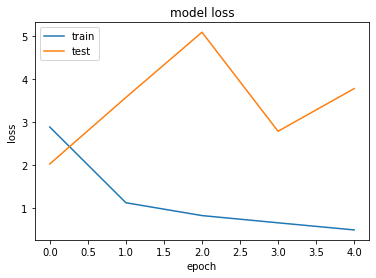

In [20]:
plot_loss_accuracy(model5)

This model provided different variety of results like below but with the above run, the model is over fitting
 - Model Overfitting
 - Model ended-up saying Out of Memory
 - As I m using early stop mechanism with patience set to 5, the model is not improving w.r.t to validation loss, so it stopped training with 5-7 echos only( so results in write-up and notebook may vary)


## Model 6 - CNN with LSTM

In [24]:
def sample_model_LSTM():
    #write your model here
    modelE = Sequential()
    modelE.add(TimeDistributed(Conv2D(64,(3,3),padding='same',input_shape=(18,img_width, img_height,3))))
    modelE.add(TimeDistributed(BatchNormalization()))
    modelE.add(TimeDistributed(Activation('relu')))
    modelE.add(TimeDistributed(MaxPooling2D((2,2))))

    modelE.add(TimeDistributed(Conv2D(128,(2,2),padding='same')))
    modelE.add(TimeDistributed(BatchNormalization()))
    modelE.add(TimeDistributed(Activation('relu')))
    #model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,1)))
    modelE.add(TimeDistributed(MaxPooling2D((2,2))))

    modelE.add(TimeDistributed(Conv2D(256,(3,3),padding='same')))
    modelE.add(TimeDistributed(BatchNormalization()))
    modelE.add(TimeDistributed(Activation('relu')))
    modelE.add(TimeDistributed(MaxPooling2D((2,2))))

    modelE.add(TimeDistributed(Conv2D(256,(3,3),padding='same')))
    modelE.add(TimeDistributed(BatchNormalization()))
    modelE.add(TimeDistributed(Activation('relu')))
    modelE.add(TimeDistributed(MaxPooling2D((2,2))))

    modelE.add(TimeDistributed(Flatten()))
    modelE.add(LSTM(64))
    modelE.add(Dropout(0.5))
    modelE.add(Dense(512, activation = 'relu'))
    #modelE.add(Dropout(0.5))
    modelE.add(Dense(5,activation = 'softmax'))
    
    
    #After Model Building Code Block
    #optimiser = optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True)
    optimiser = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True)
    #,weight_decay=None,clipnorm=None,clipvalue=None,global_clipnorm=None,use_ema=False,ema_momentum=0.99,ema_overwrite_frequency=None,jit_compile=True,) #write your optimizer
    modelE.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])#
    #print(modelE.summary())
    return modelE


In [29]:
img_width = 160
img_height = 160
batch_size=8
num_epochs = 25
img_idx=[0,1,2,3,4,5,7,9,11,13,15,17,19,21,23,25,27,29] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
print("No of Frames Used", len(img_idx))
modelF = sample_model_LSTM()
#model.summary()
model6=train_model(modelF,batch_size, True)
modelF.summary()

No of Frames Used 18
Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.5888 - categorical_accuracy: 0.2496Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2023-09-0609_57_57.622262/model-00001-1.58883-0.24962-1.65060-0.16000.h5
83/83 [==============================] - 93s 1s/step - loss: 1.5888 - categorical_accuracy: 0.2496 - val_loss: 1.6506 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.4292 - categorical_accuracy: 0.4261
Epoch 00002: saving model to model_init_2023-09-0609_57_57.622262/model-00002-1.42923-0.42609-1.86543-0.18000.h5
83/83 [==============================] - 88s 1s/step - loss: 1.4292 - categorical_accuracy: 0.4261 - val_loss: 1.8654 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.2721 - ca

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


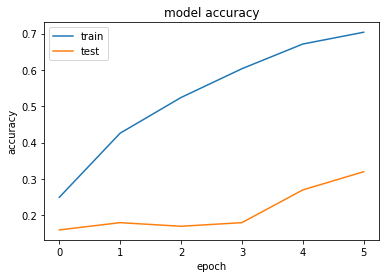

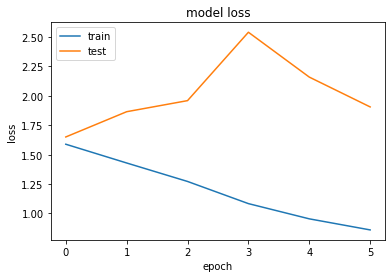

In [30]:
plot_loss_accuracy(model6)

**Model is overfitting but the trainable parameters have come down, lets try with GRU**

## Model 7 - CNN+ GRU

In [26]:
def sample_model_GRU():
    #write your model here
    modelF = Sequential()
    modelF.add(TimeDistributed(Conv2D(64,(3,3),padding='same',input_shape=(18,img_width, img_height,3))))
    modelF.add(TimeDistributed(BatchNormalization()))
    modelF.add(TimeDistributed(Activation('relu')))
    modelF.add(TimeDistributed(MaxPooling2D((2,2))))

    modelF.add(TimeDistributed(Conv2D(128,(2,2),padding='same')))
    modelF.add(TimeDistributed(BatchNormalization()))
    modelF.add(TimeDistributed(Activation('relu')))
    #model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,1)))
    modelF.add(TimeDistributed(MaxPooling2D((2,2))))

    modelF.add(TimeDistributed(Conv2D(256,(3,3),padding='same')))
    modelF.add(TimeDistributed(BatchNormalization()))
    modelF.add(TimeDistributed(Activation('relu')))
    modelF.add(TimeDistributed(MaxPooling2D((2,2))))

    modelF.add(TimeDistributed(Conv2D(256,(3,3),padding='same')))
    modelF.add(TimeDistributed(BatchNormalization()))
    modelF.add(TimeDistributed(Activation('relu')))
    modelF.add(TimeDistributed(MaxPooling2D((2,2))))

    modelF.add(TimeDistributed(Flatten()))
    modelF.add(GRU(64))
    modelF.add(Dropout(0.5))
    modelF.add(Dense(512, activation = 'relu'))
    #modelF.add(Dropout(0.25))
    modelF.add(Dense(5,activation = 'softmax'))
    
    #After Model Building Code Block
    #optimiser = optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True)
    optimiser = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True)
    #,weight_decay=None,clipnorm=None,clipvalue=None,global_clipnorm=None,use_ema=False,ema_momentum=0.99,ema_overwrite_frequency=None,jit_compile=True,) #write your optimizer
    modelF.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])#
    #print(modelE.summary())
    return modelF


In [27]:
img_width = 160
img_height = 160
batch_size=8
num_epochs = 25
img_idx=[0,1,2,3,4,5,7,9,11,13,15,17,19,21,23,25,27,29] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
print("No of Frames Used", len(img_idx))
model = sample_model_GRU()
#model.summary()
model7=train_model(model,batch_size, True)
model.summary()

No of Frames Used 18
Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.5128 - categorical_accuracy: 0.3265Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: saving model to model_init_2023-09-0609_18_37.393416/model-00001-1.51284-0.32655-2.03460-0.23000.h5
83/83 [==============================] - 103s 1s/step - loss: 1.5128 - categorical_accuracy: 0.3265 - val_loss: 2.0346 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.3015 - categorical_accuracy: 0.4540
Epoch 00002: saving model to model_init_2023-09-0609_18_37.393416/model-00002-1.30149-0.45400-2.49593-0.18000.h5
83/83 [==============================] - 98s 1s/step - loss: 1.3015 - categorical_accuracy: 0.4540 - val_loss: 2.4959 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.1394 - c

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


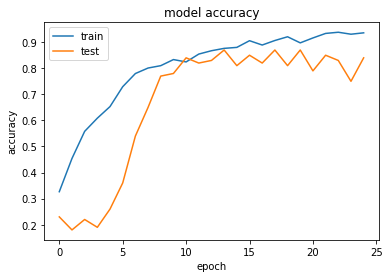

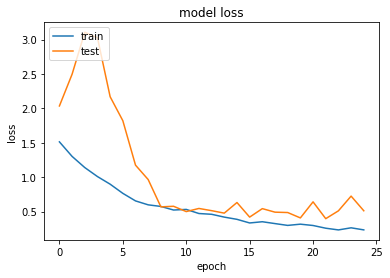

In [28]:
plot_loss_accuracy(model7)

**With Conv2D+GRU, the model performance is Good with training – 0.8974 and val -0.8700 with validation loss 0.4, also the no. of trainable parameters here is significally less than the Conv3D Model 4 above**


## Model 8 -- with all frames

In [ ]:
img_width = 160
img_height = 160
batch_size=8
num_epochs = 25
img_idx=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
print("No of Frames Used", len(img_idx))
modelh = sample_model()
modelh.summary()
model8=train_model(modelh,batch_size, True)

**With all 30 frames as input, the model threw Outof Memory issue**

## Model 9 -- with alternate frames and image size changed to 100x100

In [27]:
def sample_model_idropOut():
  #write your model here
  modelI = Sequential()
  modelI.add(Conv3D(64,(3,3,3),padding='same',input_shape=(18,img_width, img_height,3)))
  modelI.add(BatchNormalization())
  modelI.add(Activation('relu'))
  modelI.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

  modelI.add(Conv3D(128,(3,3,3),padding='same'))
  modelI.add(BatchNormalization())
  modelI.add(Activation('relu'))
  #model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,1)))
  modelI.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

  modelI.add(Conv3D(256,(3,3,3),padding='same'))
  modelI.add(BatchNormalization())
  modelI.add(Activation('relu'))
  modelI.add(MaxPooling3D(pool_size=(2, 2,2), strides=(2,2,2)))

  modelI.add(Conv3D(256,(3,3,3),padding='same'))
  modelI.add(BatchNormalization())
  modelI.add(Activation('relu'))
  modelI.add(MaxPooling3D(pool_size=(2, 2,2), strides=(2,2,2)))

  modelI.add(Flatten())
  modelI.add(Dropout(0.5))
  modelI.add(Dense(512, activation = 'relu'))
  #model.add(Activation('elu'))
  modelI.add(Dropout(0.5))
  #model.add(Dense(len(class_names)))
  modelI.add(Dense(5,activation = 'softmax'))

  optimiser = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True)
  #,weight_decay=None,clipnorm=None,clipvalue=None,global_clipnorm=None,use_ema=False,ema_momentum=0.99,ema_overwrite_frequency=None,jit_compile=True,) #write your optimizer
  modelI.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  #print (modelA.summary())
  return modelI

In [28]:
img_width = 100
img_height = 100
batch_size=15
num_epochs = 10
img_idx=[0,1,2,3,4,5,7,9,11,13,15,17,19,21,23,25,27,29]
print("No of Frames Used", len(img_idx))
modelI = sample_model()
modelI.summary()
model9=train_model(modelI,batch_size, True)

No of Frames Used 18
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 100, 100, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 50, 100, 64)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 50, 100, 128)   221312    
                                                                 
 batch_normalization_9 (Batc  (No

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


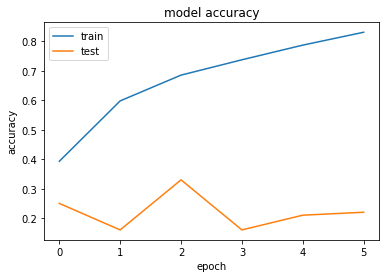

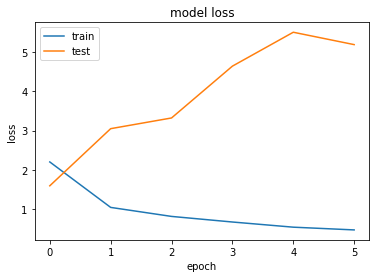

In [29]:
plot_loss_accuracy(model9)

**When image size reduced to 100x100, there is no improvement in the accuracy**

## Model 10 - Similar to model4 with LR changed

In [34]:
def sample_model_lr():
  #write your model here
  modellr = Sequential()
  modellr.add(Conv3D(64,(3,3,3),padding='same',input_shape=(18,img_width, img_height,3)))
  modellr.add(BatchNormalization())
  modellr.add(Activation('relu'))
  modellr.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

  modellr.add(Conv3D(128,(3,3,3),padding='same'))
  modellr.add(BatchNormalization())
  modellr.add(Activation('relu'))
  #model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,1)))
  modellr.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))

  modellr.add(Conv3D(256,(3,3,3),padding='same'))
  modellr.add(BatchNormalization())
  modellr.add(Activation('relu'))
  modellr.add(MaxPooling3D(pool_size=(2, 2,2), strides=(2,2,2)))

  modellr.add(Conv3D(256,(3,3,3),padding='same'))
  modellr.add(BatchNormalization())
  modellr.add(Activation('relu'))
  modellr.add(MaxPooling3D(pool_size=(2, 2,2), strides=(2,2,2)))

  modellr.add(Flatten())
  modellr.add(Dropout(0.25))
  modellr.add(Dense(512, activation = 'relu'))
  #model.add(Activation('elu'))
  #modelA.add(Dropout(0.25))
  #model.add(Dense(len(class_names)))
  modellr.add(Dense(5,activation = 'softmax'))

  optimiser = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True)
  #,weight_decay=None,clipnorm=None,clipvalue=None,global_clipnorm=None,use_ema=False,ema_momentum=0.99,ema_overwrite_frequency=None,jit_compile=True,) #write your optimizer
  modellr.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  #print (modelA.summary())
  return modellr

In [35]:
img_width = 160
img_height = 160
batch_size=8
num_epochs = 25
img_idx=[0,1,3,5,7,9,11,13,15,17,18,19,21,23,25,26,27,29] #,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
print("No of Frames Used", len(img_idx))
modellr = sample_model_lr()
#print(model)
modellr.summary()
model10=train_model(modellr,batch_size, True)

No of Frames Used 18
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 18, 160, 160, 64)  5248      
                                                                 
 batch_normalization_20 (Bat  (None, 18, 160, 160, 64)  256      
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 18, 160, 160, 64)  0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 9, 80, 160, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 9, 80, 160, 128)   221312    
                                                                 
 batch_normalization_21 (Bat  (No

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


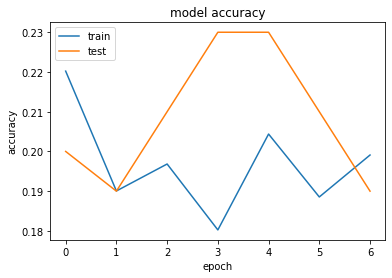

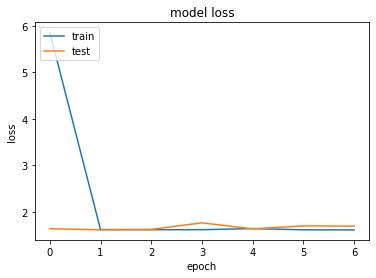

In [36]:
plot_loss_accuracy(model10)

**With the updated LR rate, the model is underfitting**